# Exercise. ASI

# Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.special import logsumexp
from scipy.stats import norm
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from sklearn import metrics
from skimage.color import rgb2gray
import copy
import tensorflow as tf
from tensorflow.contrib.layers  import flatten
import time
from sklearn.metrics import mean_squared_error

# 1. Load data

 Download the Fashion MNIST and CIFAR10 datasets and import them. 

In [2]:
cifarBase = "cifar-10-batches-py"
cifarTrainName = "data_batch_"
cifarSize = 1024
fashion_label_desc = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
cifar_label_desc = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
  
def readCifarData():
    cifarTest = unpickle(cifarBase + "/" + "test_batch")
    cifarTrain = [unpickle(cifarBase + "/" + cifarTrainName + str(i)) for i in range(1,6)]
    cifarTestLabels = cifarTest[b'labels']
    cifarTestData = cifarTest[b'data']
    
    # merge all the batches and split into labels and data
    cifarTrainLabels = np.concatenate([batch[b'labels'] for batch in cifarTrain])
    cifarTrainData = np.concatenate([batch[b'data'] for batch in cifarTrain])
    
    # change data order so that color channels are located together
    cifarTrainData = np.dstack((cifarTrainData[:, :1024], cifarTrainData[:, 1024:2048], cifarTrainData[:, 2048:]))
    cifarTestData = np.dstack((cifarTestData[:, :1024], cifarTestData[:, 1024:2048], cifarTestData[:, 2048:]))
    
    # format data into pixels
    cifarTrainData = cifarTrainData.reshape(-1,1024, 3)
    cifarTestData = cifarTestData.reshape(-1,1024, 3)

    return cifarTrainLabels,cifarTrainData,cifarTestLabels,cifarTestData

In [3]:
fashionTest = pd.read_csv("fashion-mnist_test.csv")
fashionTrain = pd.read_csv("fashion-mnist_train.csv")
cifarTrainLabels,cifarTrainData,cifarTestLabels,cifarTestData = readCifarData()
rgbCifarTrainData = cifarTrainData.reshape(-1,1024 * 3)
rgbCifarTestData = cifarTestData.reshape(-1,1024 * 3)
grayCifarTrainData = rgb2gray(cifarTrainData)
grayCifarTestData = rgb2gray(cifarTestData)

In [4]:
y_fashion = fashionTrain.label.values
X_fashion = fashionTrain.drop("label",axis=1).values / 255
y_fashion_test = fashionTest.label.values
X_fashion_test = fashionTest.drop("label",axis=1).values / 255

y_cifar = cifarTrainLabels
X_cifar = grayCifarTrainData
X_cifar_rgb = rgbCifarTrainData
y_cifar_test = cifarTestLabels
X_cifar_test = grayCifarTestData
X_cifar_test_rgb = rgbCifarTestData

# 2. Comment data

Comment on the distribution of class labels and the dimensionality of the input and how these may
affect the analysis.

In [5]:
print("Fashion MNIST train shape:",fashionTrain.shape)
print("Fashion MNIST test shape:",fashionTest.shape)
print()
print("CIFAR10 train shape:",cifarTrainData.shape)
print("CIFAR10 test shape:",cifarTestData.shape)
print()
print("Grayscale CIFAR10 train shape:",grayCifarTrainData.shape)
print("Grayscale CIFAR10 test shape:",grayCifarTestData.shape)

Fashion MNIST train shape: (60000, 785)
Fashion MNIST test shape: (10000, 785)

CIFAR10 train shape: (50000, 1024, 3)
CIFAR10 test shape: (10000, 1024, 3)

Grayscale CIFAR10 train shape: (50000, 1024)
Grayscale CIFAR10 test shape: (10000, 1024)


From the shapes above we see that the CIFAR10 entries have much more features than the Fashion MNIST entries. This is because CIFAR10 images are colored while Fashion MNIST images are greyscale. Eventualy this may mean that we will run into some space issues as the CIFAR10 dataset will take atleast 740MB of RAM space (most likely more). The greyscaled version of the CIFAR10 dataset will only take one third of the original datasets space, which is much better for our algorithms. There may be a imformation tradeof by using greyscaled images instead, as by transforming them we lose some of the original image's information. One other thing that we notice is that MNIST images are 28x28 while CIFAR10 images are 32x32.

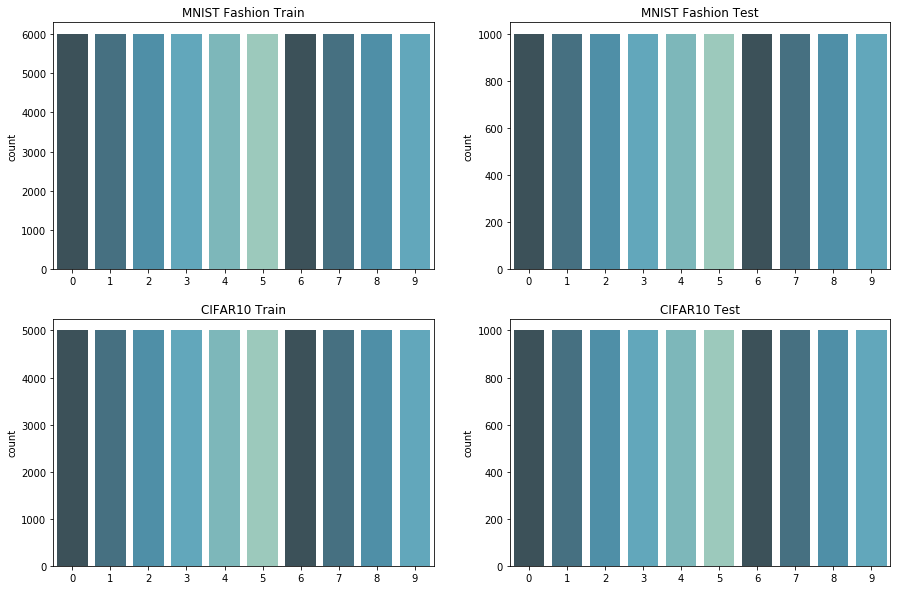

In [6]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.title("MNIST Fashion Train")
sns.countplot(y_fashion,palette=sns.color_palette("GnBu_d"))
plt.subplot(222)
plt.title("MNIST Fashion Test")
sns.countplot(y_fashion_test,palette=sns.color_palette("GnBu_d"))
plt.subplot(223)
plt.title("CIFAR10 Train")
sns.countplot(y_cifar,palette=sns.color_palette("GnBu_d"))
plt.subplot(224)
plt.title("CIFAR10 Test")
sns.countplot(y_cifar_test,palette=sns.color_palette("GnBu_d"))
plt.show()

From the countplots above we can see that all labels are represented equaly in both the dataset. This means that our predictions will not be biased by some labels more than others, which is good.

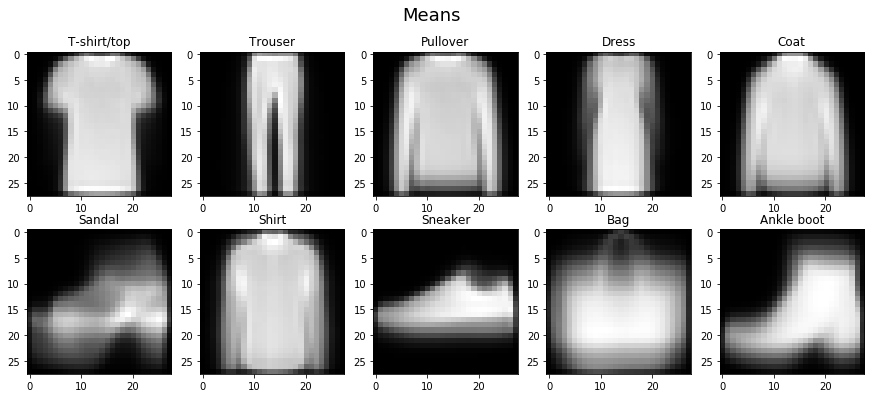

In [7]:
mnistDF = pd.DataFrame(data=X_fashion)
mnistDF["label"] = y_fashion
mnist_means = mnistDF.groupby("label").mean().values.reshape(10,28,28)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Means', fontsize=18)
for ax, label, image in zip(axes.flat, fashion_label_desc, mnist_means):
    ax.imshow(image, cmap='gray', interpolation='none')
    ax.set_title(label)
plt.show()

The plots above shows the mean of all the labels in the Fashion MNIST dataset. We can see that some of the classes are quite similar, especially Pullover,Coat and Shirt. These three may be hard for our algorithm to distinguish between. We will later see if our algorithms fails to distinguish these three when we plot the confusion matrix for our predictions. 

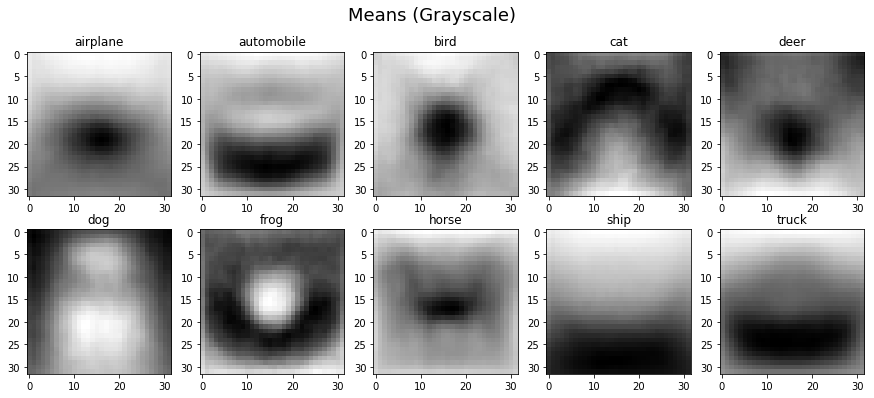

In [8]:
cifarDF = pd.DataFrame(data=X_cifar)
cifarDF["label"] = y_cifar
cifar_means = cifarDF.groupby("label").mean().values.reshape(10,32,32)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Means (Grayscale)', fontsize=18)
for ax, label, image in zip(axes.flat, cifar_label_desc, cifar_means):
    ax.imshow(image, cmap='gray', interpolation='none')
    ax.set_title(label)
plt.show()

The CIFAR10 dataset will probably be much harder to predict correctly than the Fashion MNIST dataset. The plots above are for many classes quite similar, and many of them dont have very distinguishing feature areas compared to the others.

# 3. Classification

## 3.a) Implement the Naïve Bayes classifier

The formula for the naive bayes classifier is the following:
<br><br>
$$P(t_{new} = k|X,t,x_{new})=\frac{P(x_{new}|t_{new} = k,X,t)\dot P(t_{new}=k)}{\sum_j P(x_{new}|t_{new}=j,X,t)\dot P(t_{new}=j))}$$
<br><br> 
Naive Bayes makes the assumption that all features are independent, so our likelihood folmula will be:
<br><br>
$$p(x_{new}|t_{new}=k,X,t)=\prod_{d=1}^D p(x_d^{new}|t_{new}=k,X,t)$$
<br><br>
We will be using log-likelihood as our unit of measure, and since are predicting over all classes we can remove the marginal likelihood from our formula. So our final formula will be
<br><br>
$$Posterior = ln(likelihood) + ln(prior)$$
<br><br>
where the ln(likelihood) formula is 
<br><br>
$$ ln(likelihood)=-\frac{d}{2}ln(2\pi)-\frac{1}{2}ln(variance)-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)$$
<br><br>
and the prior is
<br><br>
$$prior = \frac{1}{num_{classes}}$$

In [14]:
class NaiveBayesClassifier(object):
    def calcLogLikelihood(self,X,mean,var):
        return mvn.logpdf(X, mean=mean, cov=var)
        
    def fit(self,X,Y):
        X = pd.DataFrame(data=copy.deepcopy(X))
        X["label"] = Y
        self.labels = sorted(X["label"].unique())
        self.mean = X.groupby("label").mean()
        self.var = X.groupby("label").var()
        
    
    def logLikelihood(self,x,t):
        mean = self.mean.loc[t].values
        
        #make variance positive semidefinit
        var = self.var.loc[t].values + 1e-2
        
        log_likelihood = self.calcLogLikelihood(x,mean,var)
        return log_likelihood
    
    def prior(self):
        return 1 / len(self.labels)
    
    def posterior(self,x,t):
        return self.logLikelihood(x,t) + np.log( self.prior())
    
    def predict(self,X):
        p = np.array([self.posterior(X,t) for t in self.labels]).T
        return p.argmax(axis=1)
    
    def score(self,X,y):
        preds = self.predict(X)
        return np.mean(preds == y)

## 3.b)  Describe a positive and a negative feature of the classifier for these tasks

### Positive:
The Naive Bayes method is a very simple method to implement. It assumes independence of features, so all that needs to be calculated is the mean an variance of each class. This means that we can process high dimentional feature vectors without problems. One other positive feature of the Naive Bayes classifier is that the model don't have any hyperparameters that needs tuning.
### Negative:
The positive features of the Naive Bayes classifier are also negative ones. Since it assumes feature independence, we are basically saying that pixels are not related to each other, wich in many cases are not correct.

## 3.c) Describe any data pre-processing that you suggest for this data and your classifier

For the fashion MNIST dataset we are normalizing the values to a value in the range [0,1]. 
For the CIFAR10 we are tranforming the RGB values into grayscale values in the range [0,1].

## 3.d) Apply your classifier to the two given datasets. Make sure your optimization is clearly commented. Use classification accuracy and test log-likelihood as your figures of merit

### Optimization

The optimization i have done is to turn the CIFAR10 images into grayscale. This is done to drastically reduce the number of features to one third. I have also normalized the Fashion Mnist pixel values to be between 0 and 1.

### Fashion MNIST

In [17]:
classifierMnist = NaiveBayesClassifier()
classifierMnist.fit(X_fashion,y_fashion)
accuracy = classifierMnist.score(X_fashion_test,y_fashion_test)
print("Accuracy =","{0:.2f}".format(accuracy*100),"%")

Accuracy = 67.90 %


### CIFAR10

In [18]:
# using grayscale data
classifierCifar = NaiveBayesClassifier()
classifierCifar.fit(X_cifar,y_cifar)
accuracy = classifierCifar.score(X_cifar_test,y_cifar_test)
print("Accuracy =","{0:.2f}".format(accuracy*100),"%")

Accuracy = 25.54 %


In [19]:
# using RBG color data
classifier = NaiveBayesClassifier()
classifier.fit(X_cifar_rgb,y_cifar)
accuracy = classifier.score(X_cifar_test_rgb,y_cifar_test)
print("Accuracy =","{0:.2f}".format(accuracy*100),"%")

Accuracy = 29.76 %


We can see that the accuracy is higher when using colors instead of grayscale. But because of memory issues i will only be using the grayscale images going foreward.

## 3.e)  Display the confusion matrix on the test data

### Fashion MNIST

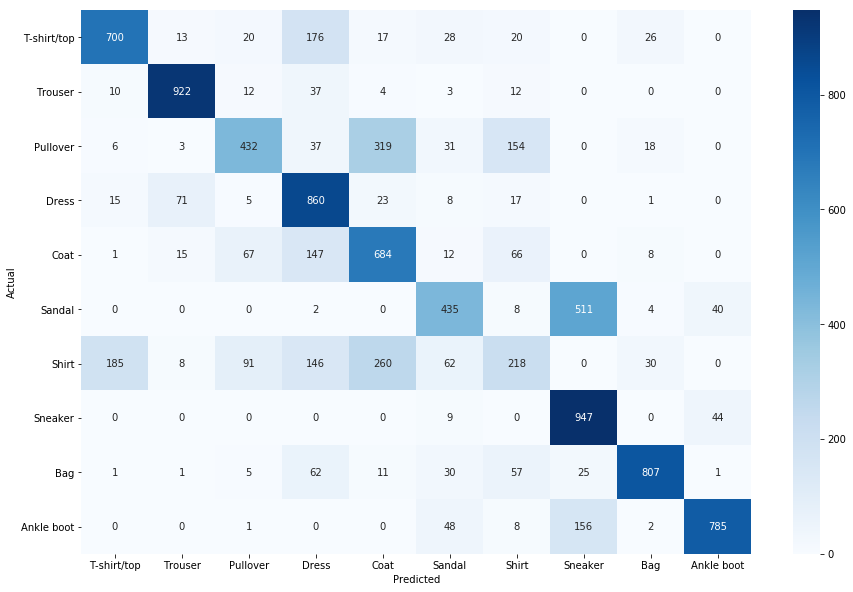

In [13]:
cf = np.zeros((10,10))
for pred,t in zip(classifierMnist.predict(X_fashion_test),y_fashion_test):
    cf[t][pred] += 1
plt.figure(figsize=(15,10))

df = pd.DataFrame(data=cf.astype(int),columns=fashion_label_desc)
df.index = fashion_label_desc

sns.heatmap(df,annot=True, fmt="d",cmap="Blues")
plt.yticks(rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

As we saw earlier Pullover, Coat and Shirt are hard to distinguish for our Naive Bayes model. Other classes that seems to be miss classified are sandals as sneakers. If we look back at the mean plots from earlier, we can see that also those where quite similar.

### CIFAR10

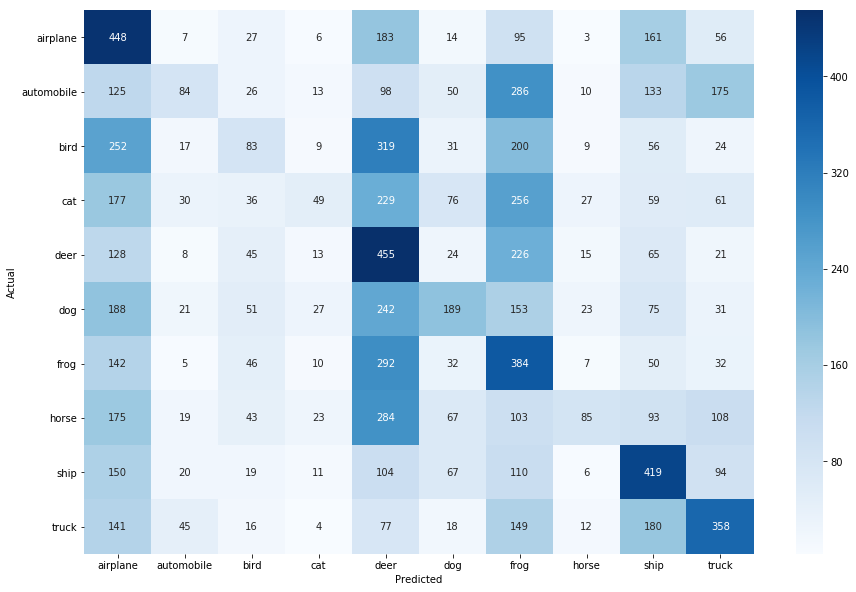

In [14]:
cf = np.zeros((10,10))
for pred,t in zip(classifierCifar.predict(X_cifar_test),y_cifar_test):
    cf[t][pred] += 1
plt.figure(figsize=(15,10))

df = pd.DataFrame(data=cf.astype(int),columns=cifar_label_desc)
df.index = cifar_label_desc

sns.heatmap(df,annot=True, fmt="d",cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.yticks(rotation=0) 
plt.show()

Here we see that not many of our classes are well predicted. Airplane, deer and dog have a high number of correct predictions. But these classes also have a high number of false predictions, so the total accuracy is not that high.

## 3.f) Discuss the performance, compare them against a classifier that outputs random class labels, and suggest ways in which performance could be improved

In [15]:
class RandomClassifier(object):
    def predict(self,X):
        return np.random.random_integers(low=0,high=9,size=len(X))
    
    def score(self,X,y):
        preds = self.predict(X)
        return np.mean(preds == y)

In [16]:
classifier = RandomClassifier()
print("Accuracy on CIFAR10:",classifier.score(X_cifar_test,y_cifar_test))
print("Accuracy on Fashion MNIST:",classifier.score(X_fashion_test,y_fashion_test))

Accuracy on CIFAR10: 0.1036
Accuracy on Fashion MNIST: 0.0982


As expected the random classifier achieves a accuracy of $\frac{1}{num_{classes}}$ which in this case is 0.1. The Naive Bayes model achieves a better accuracy than the random classifier on both datasets, but not by much on the CIFAR10 dataset.

### Improvements

In this case our features are not independent, so the asumption the Naive Bayes model makes are wrong. We could do a principal component analysis to find uncorrelated features and use only those, and se if that could help our model. Another way could be to add features that represent the spatial pixel correlations in the image.  These features could come from a convolutional neural network.

# 4. Linear Regression

## 4.a) Implement Bayesian linear regression

Our posterior distribution will be 
$$p(\boldsymbol{w}|\boldsymbol{X},\boldsymbol{t},\sigma^2)= \mathcal{N}(\boldsymbol{\mu},\boldsymbol{\Sigma})$$

where the covariance is 
$$\boldsymbol{\Sigma} = (\frac{1}{\sigma^2}\boldsymbol{X}^T\boldsymbol{X}+\boldsymbol{S}^{-1})^{-1}$$
and the mean is 
$$\boldsymbol{\mu} = \frac{1}{\sigma^2}\boldsymbol{\Sigma} \boldsymbol{X}^T \boldsymbol{t}$$
The predictive density is
$$p(t_{new}|\boldsymbol{X},\boldsymbol{t},x_{new},\sigma^2)=\mathcal{N}(x_{new}^T \boldsymbol{\mu},\sigma^2 + x_{new}^T \boldsymbol{\Sigma} x_{new})$$


In [13]:
class LinearRegressor(object):
    def findLabel(self,x):
        if (x < 0):
            return 0
        elif(x > 9):
            return 9
        return np.rint(x)
    
    def var(self,X):
        return np.var(X)
            
    def prior(self,X):
        return np.identity(X.shape[1])
    
    def addNoice(self,X,noise):
        X += np.random.randn(len(X), len(X[0])) * noise
        return X
    
    def fit(self,X,y,noise=0):
        X = copy.deepcopy(X)
        # insert intercept
        X = np.insert(X,0,1,axis=1)
        # add random noice to make x invertible
        X = self.addNoice(X,noise)
        #find variance of features
        self.var = self.var(X)
        # covariance
        self.cov = np.linalg.inv(1/self.var * X.T.dot(X) + np.linalg.inv(self.prior(X)))
        # mean
        self.mean = 1/self.var * self.cov.dot(X.T).dot(y)
         
        
    def predict(self,X):
        X = np.insert(X,0,1,axis=1)
        preds = X.dot(self.mean.reshape(-1,1))
        pred_std = self.var +  X.dot(self.cov).dot(X.T).diagonal()
        return preds,pred_std
    
        
    def score(self,X,y):
        preds,_ = self.predict(X)
        preds = np.array(list(map(self.findLabel, preds.ravel())))
        return np.mean(preds == y)

## 4.b)  Treat class labels as continuous and apply regression to the training data

### Fashion MNIST

In [21]:
linearRegressorMnist = LinearRegressor()
linearRegressorMnist.fit(X_fashion,y_fashion,noise=0.01)
predMnist,std = linearRegressorMnist.predict(X_fashion_test)

### CIFAR10 

In [23]:
linearRegressorCifar = LinearRegressor()
linearRegressorCifar.fit(X_cifar,y_cifar)
predCifar,std = linearRegressorCifar.predict(X_cifar_test)

## 4.c)  Produce a scatter plot showing the predictions versus the true targets for the test set and compute the mean squared error on the test set

### Fashion MNIST

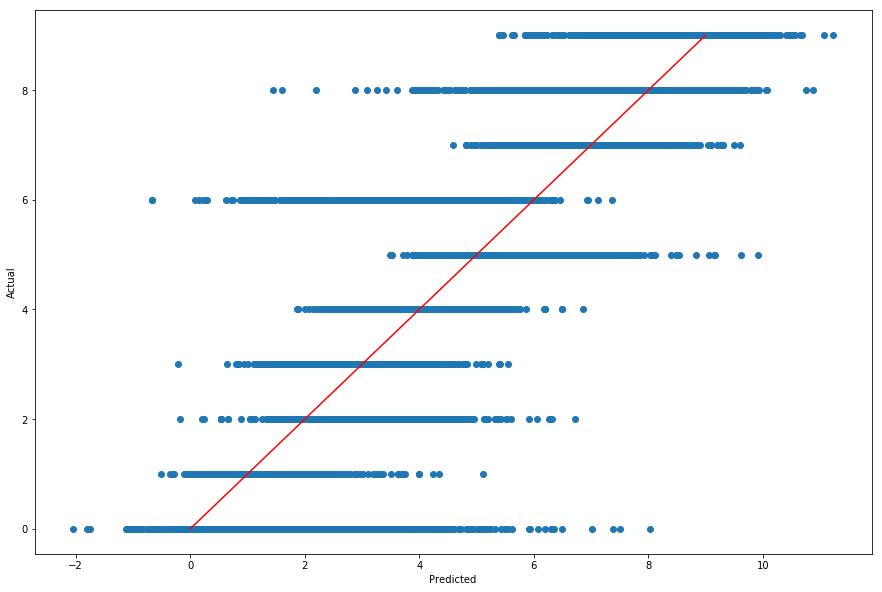

Mean square error = 1.97


In [22]:
plt.figure(figsize=(15,10))
plt.scatter(predMnist,y_fashion_test)
plt.plot([0,9],[0,9],"r")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
mse = mean_squared_error(predMnist,y_fashion_test)
print("Mean square error =","{0:.2f}".format(mse))

### CIFAR10 

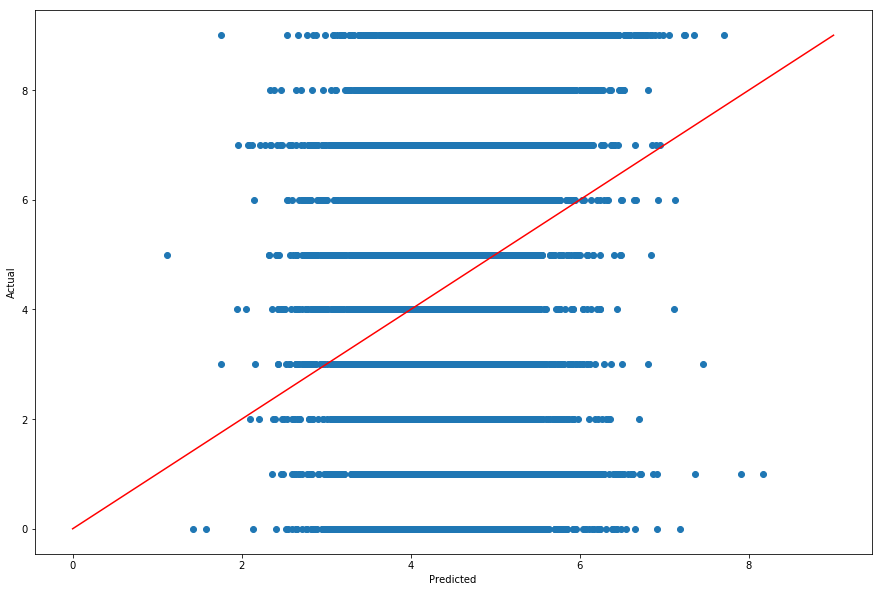

Mean square error = 8.06


In [24]:
plt.figure(figsize=(15,10))
plt.scatter(predCifar,y_cifar_test)
plt.plot([0,9],[0,9],"r")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
mse = mean_squared_error(predCifar,y_cifar_test)
#mse = np.mean(np.power(pred - y_cifar_test,2))
print("Mean square error =","{0:.2f}".format(mse))

## 4.d) Suggest a way to discretize predictions and display the confusion matrix on the test data and report accuracy

To discretize my predictions i am rounding the prediction to the closest int, and setting everything above 9 as 9, and everything below 0 as 0. This is an easy method, and the most intuitive way i could think of.

### Fashion MNIST

In [25]:
linearRegressorMnist = LinearRegressor()
linearRegressorMnist.fit(X_fashion,y_fashion)
accuracy = linearRegressorMnist.score(X_fashion_test,y_fashion_test)
print("Accuracy =","{0:.2f}".format(accuracy*100),"%")

Accuracy = 39.18 %


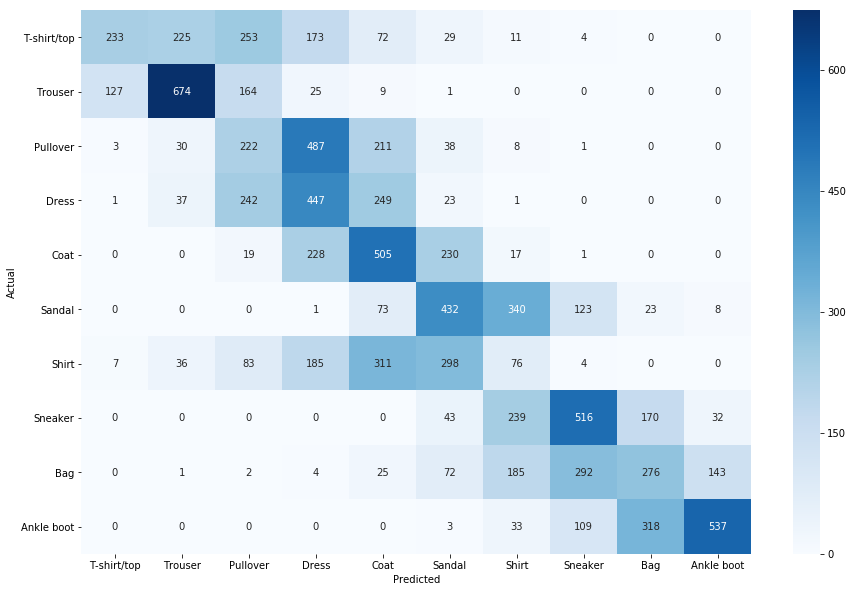

In [42]:
preds,std = linearRegressorMnist.predict(X_fashion_test)
preds_labeled = list(map(linearRegressorMnist.findLabel, preds.ravel()))

# make confusion matrix
cm = np.zeros((10,10))
for pred,t in zip(preds_labeled,y_fashion_test):
    cm[t][int(pred)] += 1

# make dataframe containing the confusion matrix and the labels as column names
df = pd.DataFrame(data=cf.astype(int),columns=fashion_label_desc)
df.index = fashion_label_desc

# plot confusion matrix
plt.figure(figsize=(15,10))
sns.heatmap(df,annot=True, fmt="d",cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.yticks(rotation=0) 
plt.show()

### CIFAR10 

In [26]:
linearRegressorCifar = LinearRegressor()
linearRegressorCifar.fit(X_cifar,y_cifar)
accuracy = linearRegressorCifar.score(X_cifar_test,y_cifar_test)
print("Accuracy =","{0:.2f}".format(accuracy*100),"%")

Accuracy = 10.11 %


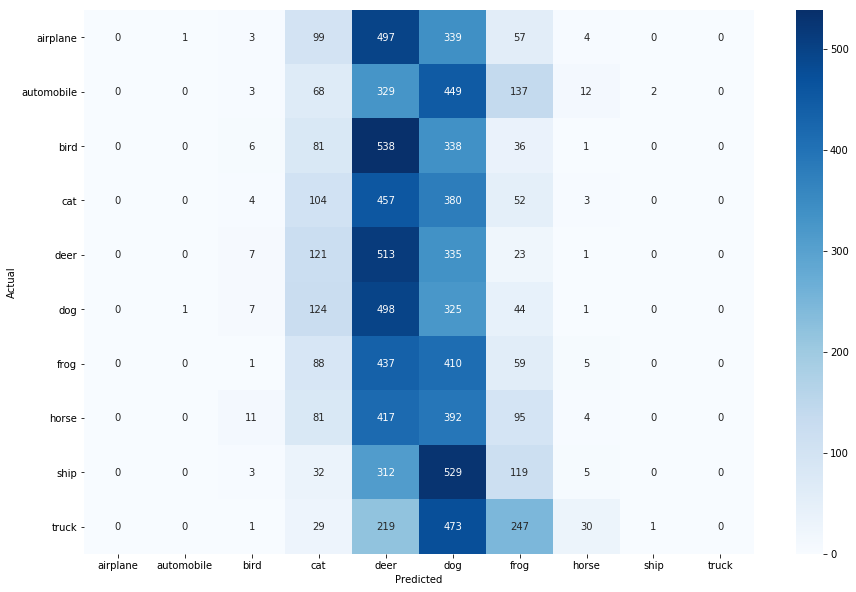

In [44]:
preds,std = linearRegressorCifar.predict(X_cifar_test)
preds_labeled = list(map(linearRegressorCifar.findLabel, preds.ravel()))

# make confusion matrix
cm = np.zeros((10,10))
for pred,t in zip(preds_labeled,y_cifar_test):
    cf[t][int(pred)] += 1

# make dataframe containing the confusion matrix and the labels as column names
df = pd.DataFrame(data=cm.astype(int),columns=cifar_label_desc)
df.index = cifar_label_desc

# plot confusion matrix
plt.figure(figsize=(15,10))
sns.heatmap(df,annot=True, fmt="d",cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.yticks(rotation=0) 
plt.show()

## 4.e) Discuss regression performance with respect to classification performance

The regression model performance performs worse than the classification model on both our datasets. The classification model obtained a accuracy of 68% on the MNIST dataset and 26% on the CIFAR10 dataset. This is much higher than the results obtained by the regression model, as they were respectivly 39% and 10%. When using the regression model on the CIFAR10 dataset, we could insead use a random classifier as the performance is the same, and computaions needed is much less. So it is safe to say that for this problem classification is better than regression. 

## 4.f) Describe one limitation of using regression for this particular task

The most obvious limitation of the regression model is that it assumes that there is a linear relationship between the features and the label. In many cases, like this one, there is a non-linear relationship between the features and the data so the model will be wrong. One other thing is that the linear regressor dont care about the structure of the data. Shuffeling the pixels would only result in a shuffleing of the weights. As for every image the structure is important for the perception, so when linear regression ignores this structure it should not be very suited for this problem.

# Bonus. CNN

To be able to extract the new features from the convolutional network, we first need to train it. We will first train the lenet5 model the regular way. Before removing the 6 last layers so that only the convolutional layers are left. Then we use the CNN model to preict on our data before using the predictions in the Naive Bayes classifier, and the linear regressor.

In [7]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K
from keras.optimizers import Adam
K.set_image_dim_ordering('th')
import os

In [8]:
class CNN(object):
    adam_optimizer = Adam(lr=0.01)
    
    def __init__(self,w,h,d,o,path):
        self.w_path = path
        self.w = w
        self.h = h
        self.d = d
        self.o = o
        self.model = self.makeModel(width=w, height=h, depth=d, output=o)
        
    def makeModel(self,height,width,depth,output):
        model = Sequential()
        model.add(Conv2D(6,(5,5),padding="same",input_shape=(depth, height, width)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Conv2D(16, (5, 5), padding="valid"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Flatten())
        model.add(Dense(120))
        model.add(Activation("relu"))
        model.add(Dense(84))
        model.add(Activation("relu"))
        model.add(Dense(output)) 
        model.add(Activation("softmax"))
        return model
    
    def fit(self,X,y):
        self.model.compile(loss="categorical_crossentropy",
                optimizer=self.adam_optimizer, metrics=["accuracy"])
        
        if(not os.path.isfile(self.w_path)):
            self.model.fit(X.reshape(-1,self.d,self.w,self.h), y, batch_size=128, epochs=20, verbose=1)
        else:
            self.loadWeights()
            
    def evaluate(self,X,y):
        return self.model.evaluate(X.reshape(-1,self.d,self.w,self.h), y ,batch_size=128, verbose=1)
    
    def saveWeights(self):
        self.model.save_weights(self.w_path, overwrite=True)
    
    def loadWeights(self):
        self.model.load_weights(self.w_path)
    
    def removeLayers(self):
        for i in range(6):
            self.model.layers.pop()
    
        self.model.outputs = [self.model.layers[-1].output]
        self.model.layers[-1].outbound_nodes = []
        self.model.compile(loss="categorical_crossentropy",
              optimizer=self.adam_optimizer, metrics=["accuracy"])
    
    def predict(self,X):
        return self.model.predict(X.reshape(-1,self.d,self.w,self.h))

In [42]:
classifier = CNN(28,28,1,10,'cnn_weights')

# need to make correct output corresponding to the network layout
y_train = np.zeros((len(y_fashion),10))
for j in range(len(y_fashion)):
    label = y_fashion[j]
    y_train[j][label] = 1

classifier.fit(X_fashion,y_train)

In [43]:
# need to make correct output corresponding to the network layout
y_test = np.zeros((len(y_fashion_test),10))
for j in range(len(y_fashion_test)):
    label = y_fashion_test[j]
    y_test[j][label] = 1

loss, accuracy = classifier.evaluate(X_fashion_test,y_test)
print("Accuracy using CNN LeNet:",accuracy*100,"%")

10000/10000 [==============================] - 7s 734us/step
Accuracy using CNN LeNet: 89.59 %


In [44]:
classifier.removeLayers()

In [45]:
X_fashion_conv = classifier.predict(X_fashion)
X_fashion_conv_test = classifier.predict(X_fashion_test)

nbClassifier = NaiveBayesClassifier()
nbClassifier.fit(X_fashion_conv,y_fashion)
lrClassifier = LinearRegressor()
lrClassifier.fit(X_fashion_conv,y_fashion,noise=0.01)

print("Accuracy using Naive Bayes:",nbClassifier.score(X_fashion_conv_test,y_fashion_test)*100,"%")
print("Accuracy using linear regression:",lrClassifier.score(X_fashion_conv_test,y_fashion_test)*100,"%")

Accuracy using Naive Bayes: 80.43 %
Accuracy using linear regression: 42.07 %


By using convolutional layers our models achieves higher accuracy. There are an increase of 11% and 3% on the MNIST dataset for the Naive Bayes and the linear regression model respectivly.

In [9]:
classifierCifar = CNN(32,32,1,10,'cnn_weights3')

y_train = np.zeros((len(y_cifar),10))
for j in range(len(y_cifar)):
    label = y_cifar[j]
    y_train[j][label] = 1

classifierCifar.fit(X_cifar,y_train)
classifierCifar.saveWeights()

Epoch 1/20
50000/50000 [==============================] - 111s 2ms/step - loss: 1.9256 - acc: 0.2800
Epoch 2/20
50000/50000 [==============================] - 98s 2ms/step - loss: 1.7403 - acc: 0.3603
Epoch 3/20
50000/50000 [==============================] - 94s 2ms/step - loss: 1.6993 - acc: 0.3821
Epoch 4/20
50000/50000 [==============================] - 89s 2ms/step - loss: 1.6607 - acc: 0.4005
Epoch 5/20
50000/50000 [==============================] - 92s 2ms/step - loss: 1.6179 - acc: 0.4183
Epoch 6/20
50000/50000 [==============================] - 88s 2ms/step - loss: 1.6001 - acc: 0.4267
Epoch 7/20
50000/50000 [==============================] - 93s 2ms/step - loss: 1.5685 - acc: 0.4408
Epoch 8/20
50000/50000 [==============================] - 89s 2ms/step - loss: 1.5370 - acc: 0.4517
Epoch 9/20
50000/50000 [==============================] - 99s 2ms/step - loss: 1.5152 - acc: 0.4606
Epoch 10/20
50000/50000 [==============================] - 87s 2ms/step - loss: 1.5054 - acc: 0.466

In [10]:
# need to make correct output corresponding to the network layout
y_test = np.zeros((len(y_cifar_test),10))
for j in range(len(y_cifar_test)):
    label = y_cifar_test[j]
    y_test[j][label] = 1

loss, accuracy = classifierCifar.evaluate(X_cifar_test,y_test)
print("Accuracy using CNN LeNet:",accuracy*100,"%")

10000/10000 [==============================] - 12s 1ms/step
Accuracy using CNN LeNet: 46.25 %


In [11]:
classifierCifar.removeLayers()

In [15]:
X_cifar_conv = classifierCifar.predict(X_cifar)
X_cifar_conv_test = classifierCifar.predict(X_cifar_test)

nbClassifier = NaiveBayesClassifier()
nbClassifier.fit(X_cifar_conv,y_cifar)
lrClassifier = LinearRegressor()
lrClassifier.fit(X_cifar_conv,y_cifar,noise=0.01)

print("Accuracy using Naive Bayes:",nbClassifier.score(X_cifar_conv_test,y_cifar_test)*100,"%")
print("Accuracy using linear regression:",lrClassifier.score(X_cifar_conv_test,y_cifar_test)*100,"%")

Accuracy using Naive Bayes: 33.72 %
Accuracy using linear regression: 11.74 %


Also the CIFAR10 dataset are predicted better using the output of the convolutional layers, but only marginaly using the linear regressor.